In [1]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


#### 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [2]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(5):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.


In [3]:
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:   #명사일 때만 tokenized에 저장
                res.append(w[0])    
        tokenized.append(res)

In [4]:
print(len(tokenized)) #명사 개수

71156


In [5]:
tokenized[:10]

[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'],
 ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'],
 ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를'],
 ['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행'],
 ['두', '사람', '날', '은수', '아파트', '밤'],
 ['사랑', '두', '사람', '상우', '주체', '수', '정도', '그녀'],
 ['겨울', '만난', '두', '사람', '관계', '봄', '지나', '여름', '맞이', '삐걱', '거', '린다'],
 ['이혼', '경험', '은수', '상우', '결혼', '생각', '표정', '내비'],
 ['사랑', '상우', '은수', '단호', '말'],
 ['것', '사랑', '그', '사실', '상우', '어찌']]

#### 2. 추출된 결과로 embedding model 만들기

In [6]:
#word2vec 임베딩모델
from gensim.models import Word2Vec

model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
#임베딩차원 100차원, 윈도우크기 5, 단어 최소 빈도수 3으로 제한, sog=0 : CBow방식

In [7]:
model.wv.most_similar(positive=['비극'])

[('극적', 0.8769263029098511),
 ('침묵', 0.8714460730552673),
 ('결말', 0.8596013784408569),
 ('광기', 0.8434047698974609),
 ('교차', 0.8244319558143616),
 ('고독', 0.8236770033836365),
 ('반전', 0.8222940564155579),
 ('동시', 0.8109775185585022),
 ('경계', 0.8065205216407776),
 ('고통', 0.8049156069755554)]

In [8]:
model.wv.most_similar(positive=['행복'])

[('기쁨', 0.9276110529899597),
 ('슬픔', 0.8948304653167725),
 ('좌절', 0.8777521848678589),
 ('아픔', 0.8760821223258972),
 ('위안', 0.8736228346824646),
 ('용기', 0.8721231818199158),
 ('용서', 0.8550378084182739),
 ('가슴', 0.8542366623878479),
 ('진정', 0.8532623052597046),
 ('눈물', 0.8529021143913269)]

#### 3. target, attribute 단어 셋 만들기
- 영화 구분(target) : 예술영화, 일반영화
- 장르 구분(attribute) : 모든 장르

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

#단어토큰만 뽑아내기
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [10]:
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [11]:
#TF-IDF : 코퍼스에서 자주 나타나는 단어이지만, 다른 코퍼스에서는 거의 나오지않는 단어 선정

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])


m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(300):
    print(vectorizer.get_feature_names_out()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(300):
    print(vectorizer.get_feature_names_out()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 청년, 한국, 가지, 상처, 할머니, 목숨, 이상, 희망, 계획, 매력, 프랑스, 사회, 제안, 만남, 무엇, 거리, 이유, 파리, 여성, 정체, 매일, 바로, 시절, 보고, 진실, 홀로, 혼란, 배우, 선택, 다큐멘터리, 혼자, 작가, 갑자기, 일본, 고향, 마주, 도착, 병원, 문제, 로부터, 노래, 주인공, 자리, 대해, 미래, 갈등, 소식, 공연, 서울, 할아버지, 부부, 도움, 연애, 회사, 여자친구, 조직, 소개, 낯선, 찾기, 애인, 잠시, 당신, 고백, 역시, 아무, 시골, 동료, 편지, 촬영, 과정, 영국, 오늘, 마침내, 지구, 마치, 자살, 뉴욕, 탈출, 무대, 주변, 학생, 열정, 발생, 고양이, 고민, 천재, 첫사랑, 더욱, 납치, 약속, 복수, 역사, 의문, 동네, 행복, 파티, 현재, 달리, 여정, 전설, 가슴, 다음, 사진, 행동, 스스로, 점차, 성공, 몰래, 등장, 살해, 부모, 누군가, 변화, 얼굴, 맞이, 작전, 전화, 목격, 나이, 남자친구, 인물, 스타, 대학, 중국, 북한, 위협, 진짜, 우정, 현장, 소설, 가정, 부모님, 주인, 의심, 시대, 카메라, 이별, 바다, 기회, 가게

예술영화 일반영화를 동시에 대표하는 중복된 단어들이 많은 것을 확인할 수 있다.

=> 두 개념축이 대조되도록 대표하는 단어 셋을 만들기 위해 중복을 제거하기

In [12]:
n = 15 #중복제거하고 15개의 대표 단어 추출
w1_, w2_ = [], []
for i in range(300):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

target_art, target_gen = [], []

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(300):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv):
        target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(300):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv):
        target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [13]:
print('예술영화를 대표하는 단어들: ', target_art)
print('일반영화를 대표하는 단어들: ', target_gen)

예술영화를 대표하는 단어들:  ['파리', '마주', '공연', '연애', '당신', '고백', '편지', '영국', '무대', '열정', '고양이', '천재', '첫사랑', '약속', '행복']
일반영화를 대표하는 단어들:  ['애니메이션', '연출', '부문', '섹스', '의도', '그것', '독립', '경쟁', '부천', '페스티벌', '환경', '다큐', '공간', '영상', '판타스틱']


In [14]:
#모든 장르의 파일
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [15]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [16]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape) #21개의 장르, 42191단어

(21, 42191)


In [17]:
m = [X[i].tocoo() for i in range(X.shape[0])] #TF-IDF로 표현한 희소행렬

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True) #정렬
    

#각 장르별 대표하는 단어 상위 15개 추출
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 시작, 

- 약간이지만 중복이 존재하기는 하나 감수하고 실험 진행

4. WEAT score 계산과 시각화

In [18]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B 
    
def weat_score(X, Y, A, B):
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [19]:
# 21 x 21 matrix 생성
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [20]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.61765355
SF 공연 -0.43820634
SF 공포(호러) -0.9103928
SF 기타 0.6295869
SF 다큐멘터리 0.9935389
SF 드라마 -0.49496576
SF 멜로로맨스 -0.89855003
SF 뮤지컬 0.52185255
SF 미스터리 -0.9277473
SF 범죄 -0.4822306
SF 사극 -1.0105517
SF 서부극(웨스턴) -0.46314815
SF 성인물(에로) -0.69516885
SF 스릴러 -0.80245495
SF 애니메이션 0.7046766
SF 액션 -0.7757595
SF 어드벤처 -1.094515
SF 전쟁 0.3827817
SF 코미디 -0.6131283
SF 판타지 -0.37258753
가족 공연 0.19914012
가족 공포(호러) -0.39505684
가족 기타 1.149056
가족 다큐멘터리 1.1698619
가족 드라마 0.24524939
가족 멜로로맨스 -0.82471114
가족 뮤지컬 0.9859372
가족 미스터리 -0.6062869
가족 범죄 0.1564785
가족 사극 -0.26837963
가족 서부극(웨스턴) 0.5856601
가족 성인물(에로) -0.5182955
가족 스릴러 -0.47966644
가족 애니메이션 1.2175798
가족 액션 -0.1321413
가족 어드벤처 -0.17408237
가족 전쟁 0.77306765
가족 코미디 0.15423717
가족 판타지 0.56377983
공연 공포(호러) -0.37351325
공연 기타 1.4632543
공연 다큐멘터리 1.3742125
공연 드라마 -0.025626045
공연 멜로로맨스 -0.7972385
공연 뮤지컬 1.4030788
공연 미스터리 -0.5572483
공연 범죄 -0.025947675
공연 사극 -0.53312916
공연 서부극(웨스턴) 0.16420294
공연 성인물(에로) -0.58296055
공연 스릴러 -0.45167375
공연 애니메이션 1.3000196
공연 액션 -0.2308830

In [21]:
#WEAR score 1기준으로 나눠서 확인
over1 = [] #1이상
under_1 = [] #-1이하

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] >= 1.0 : 
            over1.append([i, j, matrix[i][j]])
        if matrix[i][j] <= -1.0 : 
            under_1.append([i, j, matrix[i][j]])

print("[  Over 1.0 : ", len(over1), "  ]")
for i, j, score in over1:
    print(genre_name[i], genre_name[j], score)
print()
print("[  Under -1.0 : ", len(under_1), "  ]")
for i, j, score in under_1:
    print(genre_name[i], genre_name[j], score)

[  Over 1.0 :  19   ]
가족 기타 1.149056
가족 다큐멘터리 1.1698619
가족 애니메이션 1.2175798
공연 기타 1.4632543
공연 다큐멘터리 1.3742125
공연 뮤지컬 1.4030788
공연 애니메이션 1.3000196
공포(호러) 다큐멘터리 1.0785476
드라마 뮤지컬 1.0063378
드라마 애니메이션 1.0901873
멜로로맨스 뮤지컬 1.0499476
멜로로맨스 성인물(에로) 1.0880795
멜로로맨스 애니메이션 1.0711757
멜로로맨스 코미디 1.0004325
멜로로맨스 판타지 1.0013925
사극 애니메이션 1.2785338
사극 판타지 1.0788151
서부극(웨스턴) 애니메이션 1.150645
어드벤처 판타지 1.1074226

[  Under -1.0 :  24   ]
SF 사극 -1.0105517
SF 어드벤처 -1.094515
기타 드라마 -1.162621
기타 멜로로맨스 -1.1162577
기타 사극 -1.3039078
기타 서부극(웨스턴) -1.003429
기타 성인물(에로) -1.0164107
기타 어드벤처 -1.1045436
기타 코미디 -1.0853782
다큐멘터리 드라마 -1.1931063
다큐멘터리 멜로로맨스 -1.1301575
다큐멘터리 미스터리 -1.0877244
다큐멘터리 사극 -1.4009889
다큐멘터리 서부극(웨스턴) -1.1324474
다큐멘터리 성인물(에로) -1.042422
다큐멘터리 스릴러 -1.0428245
다큐멘터리 액션 -1.079961
다큐멘터리 어드벤처 -1.2941258
다큐멘터리 코미디 -1.1757644
다큐멘터리 판타지 -1.1902612
드라마 멜로로맨스 -1.0349482
뮤지컬 사극 -1.2032335
애니메이션 어드벤처 -1.1758825
애니메이션 코미디 -1.0644057


<AxesSubplot:>

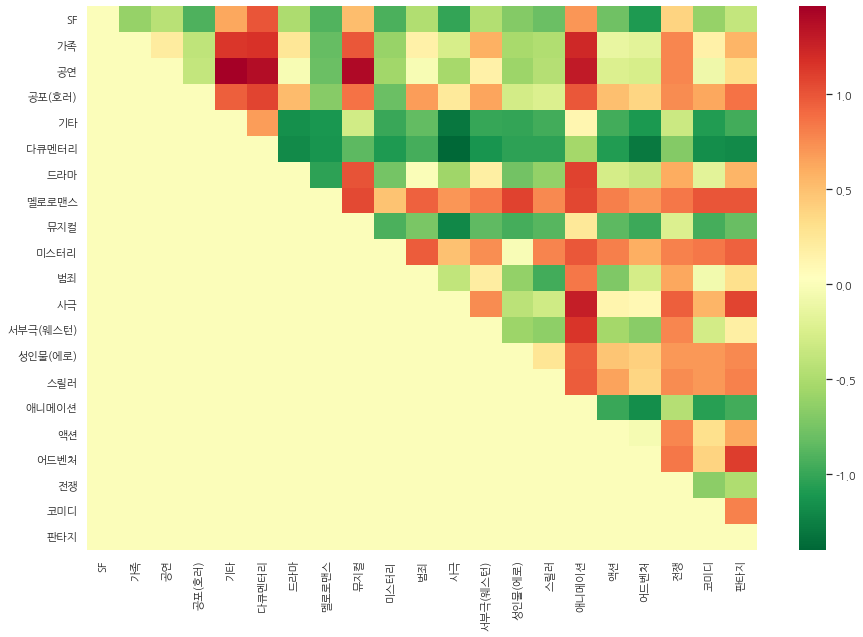

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (15,10)
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=False,  cmap='RdYlGn_r')
ax

<AxesSubplot:>

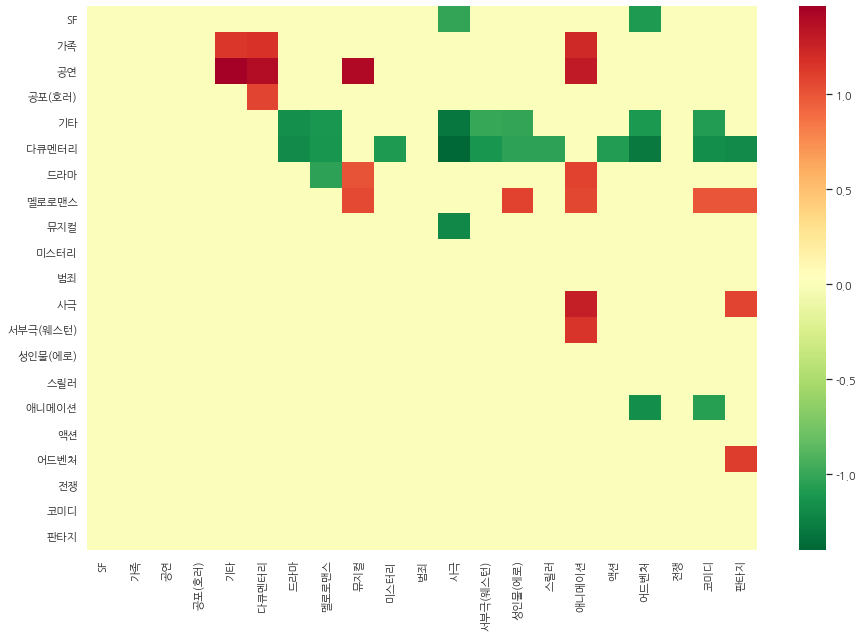

In [23]:
matrix2 = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

for i,j, score in over1:
    matrix2[i][j] = score
    
for i,j, score in under_1:
    matrix2[i][j] = score
    
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (15,10)
ax = sns.heatmap(matrix2, xticklabels=genre_name, yticklabels=genre_name, annot=False,  cmap='RdYlGn_r')
ax

---

## attribute 단어 셋 정제
- 불용어 처리
- 단어 중복 처리

In [24]:
#단어 목록
feature_names = vectorizer.get_feature_names()

# 불용어로 제거할 단어들을 정의
stop_words = ['자신', '위해', '사람', '영화', '그녀', '그', '시작'] 

# 각 장르별로 상위 15개의 단어를 추출 (중복 없이)
attributes = []
used_words = set() #이미 사용된 단어들을 추적하는 집합
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while len(attr) < 15 and j < len(w[i]):
        word_index = w[i][j][0]
        word = feature_names[word_index]
        
        #불용어X, Word2Vec 단어장의 단어O, 중복단어X,장르마다 중복단어X
        if word not in stop_words and word not in attr and word in model.wv and word not in used_words:
            attr.append(word)
            used_words.add(word)
            print(word, end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 지구, 인류, 인간, 미래, 우주, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, 
가족: 엄마, 아빠, 가족, 영화제, 친구, 아주르, 아버지, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 사랑, 
공연: 오페라, 토스카, 실황, 올레, 카바, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 왕자, 콘서트, 
공포(호러): 사건, 공포, 죽음, 악령, 남자, 좀비, 사실, 소녀, 하나, 살인, 이야기, 비밀, 아이, 정체, 저주, 
기타: 서울, 단편, 뉴미디어, 페스티벌, 여자, 대한, 독립, 작품, 통해, 아시아나, 다른, 우리, 연출, 모습, 시간, 
다큐멘터리: 다큐, 다큐멘터리, 감독, 여성, 한국, 환경, 사회, 노동자, 가장, 기록, 역사, 음악, 미국, 명의, 카메라, 
드라마: 마음, 남편, 서로, 다시, 관계, 생각, 아내, 사이, 소년, 때문, 부문, 어머니, 학교, 생활, 결혼, 
멜로로맨스: 섹스, 부부, 점점, 회사, 유혹, 연애, 애인, 새엄마, 불륜, 남자친구, 유부녀, 감정, 정사, 출장, 선배, 
뮤지컬: 뮤지컬, 에스메랄다, 충무로, 모차르트, 니웨, 바흐, 페뷔스, 프롤, 모도, 제루샤, 샤오캉, 데이비, 팬텀, 최고, 크리스틴, 
미스터리: 사고, 진실, 기억, 민혁, 의문, 미스터리, 형사, 경찰, 현우, 발생, 방독면, 과연, 범인, 살해, 모두, 
범죄: 범죄, 조직, 마약, 수사, 한길수, 계획, 은행, 작전, 동료, 보스, 한편, 상황, 마피아, 용의자, 복수, 
사극: 조선, 신기전, 아가멤논, 황제, 루안, 운명, 하선, 전쟁, 윤서, 트로이, 세자, 허균, 노준, 채선, 신재효, 
서부극(웨스턴): 서부, 보안관, 벌린, 카우보이, 그레이프바인, 헨리, 개릿, 무법자, 프린트, 마적, 태구, 현상금, 분노, 버질, 랜던, 
성인물(에로): 마사지, 에피소드, 그린, 자위, 욕구, 유이, 욕구불만, 손님, 유우, 성적, 성관계, 유코, 유미, 행각,

In [25]:
# 21 x 21 matrix 생성
matrix3 = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix3[i][j] = weat_score(X, Y, A, B)

In [26]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix3[i][j])

SF 가족 -0.7573803
SF 공연 0.07770817
SF 공포(호러) -0.8910445
SF 기타 0.46858022
SF 다큐멘터리 0.7434212
SF 드라마 -0.74969655
SF 멜로로맨스 -0.7225842
SF 뮤지컬 0.29655328
SF 미스터리 -0.8585601
SF 범죄 -0.30317554
SF 사극 -0.50880086
SF 서부극(웨스턴) -0.4689693
SF 성인물(에로) -0.5419269
SF 스릴러 -1.0484788
SF 애니메이션 0.46580783
SF 액션 -0.24853224
SF 어드벤처 -0.50159556
SF 전쟁 0.5193975
SF 코미디 -0.8002183
SF 판타지 -0.6010964
가족 공연 0.6705795
가족 공포(호러) -0.1805756
가족 기타 1.2097518
가족 다큐멘터리 1.0438666
가족 드라마 -0.47377685
가족 멜로로맨스 -0.5783774
가족 뮤지컬 0.86068434
가족 미스터리 -0.23437311
가족 범죄 0.51596224
가족 사극 0.5937725
가족 서부극(웨스턴) 0.65354997
가족 성인물(에로) -0.20316318
가족 스릴러 -0.6004025
가족 애니메이션 1.0562813
가족 액션 0.5758136
가족 어드벤처 0.5068739
가족 전쟁 0.878076
가족 코미디 -0.39430565
가족 판타지 0.720534
공연 공포(호러) -0.5409359
공연 기타 0.32134297
공연 다큐멘터리 0.7154379
공연 드라마 -0.68750215
공연 멜로로맨스 -0.7350333
공연 뮤지컬 1.3779122
공연 미스터리 -0.57429856
공연 범죄 -0.3825789
공연 사극 -0.53043747
공연 서부극(웨스턴) -0.5500688
공연 성인물(에로) -0.5831604
공연 스릴러 -0.7151547
공연 애니메이션 0.5237671
공연 액션 -0.33885387
공연 어드벤처

In [27]:
#WEAR score 1기준으로 나눠서 확인
over1 = [] #1이상
under_1 = [] #-1이하

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix3[i][j] >= 1.0 : 
            over1.append([i, j, matrix3[i][j]])
        if matrix3[i][j] <= -1.0 : 
            under_1.append([i, j, matrix3[i][j]])

print("[  Over 1.0 : ", len(over1), "  ]")
for i, j, score in over1:
    print(genre_name[i], genre_name[j], score)
print()
print("[  Under -1.0 : ", len(under_1), "  ]")
for i, j, score in under_1:
    print(genre_name[i], genre_name[j], score)

[  Over 1.0 :  7   ]
가족 기타 1.2097518
가족 다큐멘터리 1.0438666
가족 애니메이션 1.0562813
공연 뮤지컬 1.3779122
공포(호러) 기타 1.0182545
멜로로맨스 성인물(에로) 1.2101578
사극 애니메이션 1.0841686

[  Under -1.0 :  17   ]
SF 스릴러 -1.0484788
기타 드라마 -1.1633959
기타 멜로로맨스 -1.0234082
기타 사극 -1.1138107
기타 스릴러 -1.1190121
기타 코미디 -1.4472072
기타 판타지 -1.0303997
다큐멘터리 사극 -1.2093194
다큐멘터리 스릴러 -1.05239
다큐멘터리 어드벤처 -1.2046095
다큐멘터리 코미디 -1.1877066
다큐멘터리 판타지 -1.0419534
뮤지컬 코미디 -1.0301648
미스터리 스릴러 -1.5237131
애니메이션 어드벤처 -1.2168111
애니메이션 코미디 -1.100808
애니메이션 판타지 -1.0527402


<AxesSubplot:>

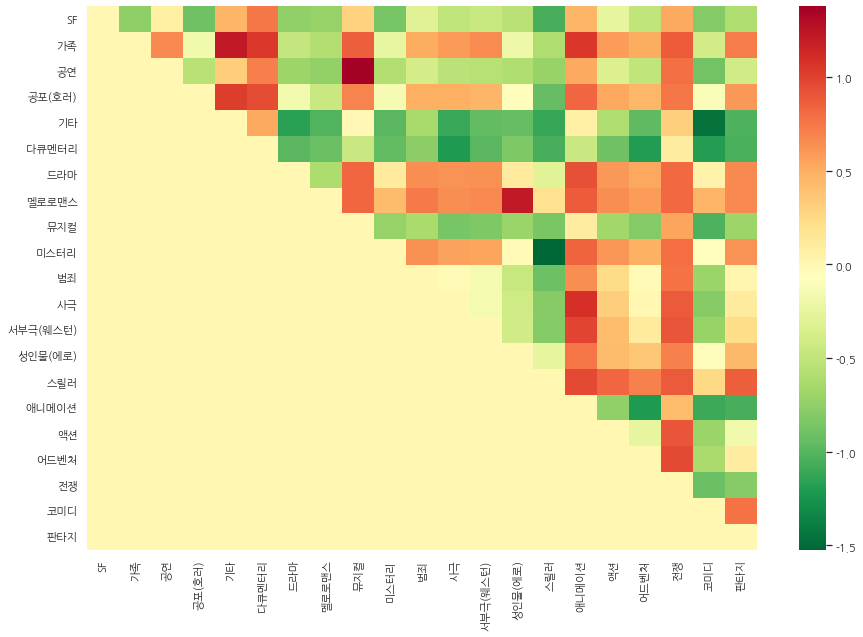

In [28]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (15,10)
ax = sns.heatmap(matrix3, xticklabels=genre_name, yticklabels=genre_name, annot=False,  cmap='RdYlGn_r')
ax

<AxesSubplot:>

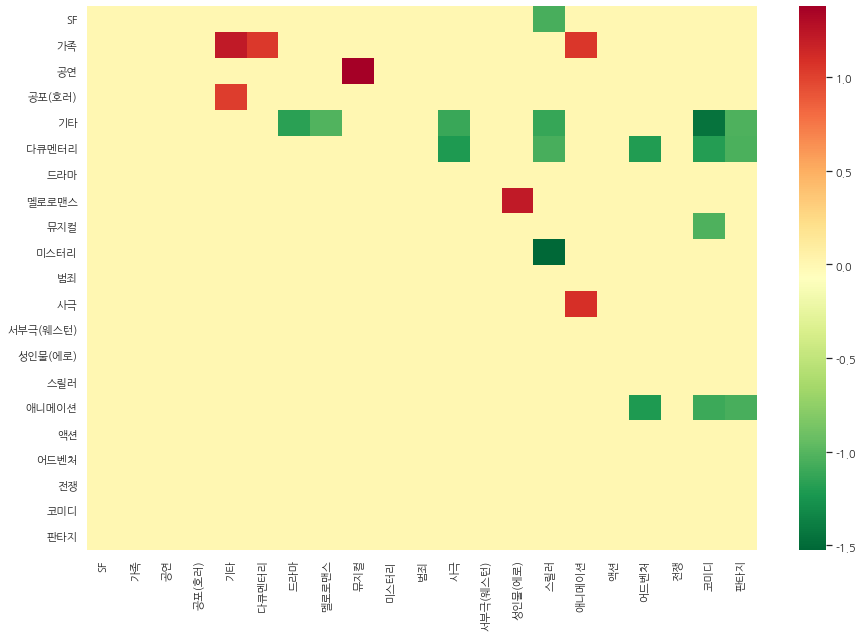

In [29]:
matrix4 = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

for i,j, score in over1:
    matrix4[i][j] = score
    
for i,j, score in under_1:
    matrix4[i][j] = score
    
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (15,10)
ax = sns.heatmap(matrix4, xticklabels=genre_name, yticklabels=genre_name, annot=False,  cmap='RdYlGn_r')
ax

### 분석 결과
||WEAT score >= 1.0|WEAT score <= -1.0|
|-----|-----|-----|
|정제 전|17|21|
|정제 후|4|14|


- 불용어와 중복을 제거해주자 WEAT score의 절대값 1.0을 넘는 경우가 줄어들었다.
  
  => 속성 단어 세트를 정제함으로써 편향성이 감소하고, 결과의 신뢰성과 일관성이 증가했음을 의미한다.
  
- 단어들이 명사들이지만 불용어로 판단한 이유

 : 장르에 따른 의미를 가진 명사가 아니라고 판단했기 때문
 
 
- 불용어의 경우 attribute에서만 제거 & target의 경우 처리가 무의미하다고 판단

=> 정제 전/후 그래프를 비교해보면 전체적으로 색이 옅어진 것을 확인할 수 있다.


### 회고
- 두 가지 속성이 두 가지 타겟 중 어느 것이 더 연관성(편향)이 있는지를 판단하는 지표로 WEAT score를 사용하는데 속성이 변함으로써 비교군이 변한다고 판단이 되어 편향성의 기준이 모호한 것 같아 해당 지표 이외의 판단 방법을 더 찾아보고 싶다.